<a href="https://colab.research.google.com/github/zoegarm/Analisis_INE_2021/blob/main/Analsis_BD_INE_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns 
import numpy as np
from wordcloud import WordCloud
from nltk.util import ngrams


sns.set_style('darkgrid')

In [103]:
#cargo la "base de datos" del ine: 
ine = 'https://candidaturas.ine.mx/documentos/descargas/baseDatosCandidatos.xls'

df = pd.read_excel(ine)

In [104]:
#cambio los nombres de las columnas: 

names = list(df)
names[10] = 'DIRECCION' #direccion de la candidatura
names = [name.lower() for name in names]

#hago un diccionario para realizar un mapeo: 

mapa_nombres = {list(df)[i]:names[i] for i in range(len(names))}
mapa_nombres 

#remapo los nombres de las columnas: 

df = df.rename(columns= mapa_nombres)

#relleno los NaN con strings vacíos: 
df = df.fillna('')

In [105]:
#hag una columna extra para sacar el num de distrito y normalizar: 
df['distrito_num'] = df["distrito"].str.strip().str.split('-', expand = True).iloc[:, 0]

In [106]:
#también puedo dividir por representación proporcional (RP) y representación de mayoría relativa (MR) para intentar normalizar otro poquito la BD:

df['candidatura_tipo'] = df['candidatura'].str.strip().str.split(expand = True).iloc[:,2]

In [107]:
#saco solo los candidatos titulares (en este DF dejamos fuera a los suplentes)
df_propietarios = df[(df['tipo_candidato'] == 'PROPIETARIO')].reset_index(drop = True)

In [108]:
display(df_propietarios.head(3))

,partido_coalicion,candidatura,entidad,distrito,circunscripcion,num_lista_o_formula,nombre_candidato,tipo_candidato,edad,genero,direccion,telefono,correo_electronico,pagina_web,redes,escolaridad,estatus_escolaridad,cursos,historia_profesional,trayectoria_politica,motivo_cargo_publico,propuesta_1,propuesta_2,propuesta_genero,distrito_num,candidatura_tipo
0,PARTIDO DEL TRABAJO,DIPUTACIÓN FEDERAL MR,AGUASCALIENTES,1-JESUS MARIA,2,4747,JUAN MANUEL DE LOERA MARQUEZ,PROPIETARIO,59,HOMBRE,,,,,,,,,,,,,,,1,MR
1,PARTIDO VERDE ECOLOGISTA DE MÉXICO,DIPUTACIÓN FEDERAL MR,AGUASCALIENTES,1-JESUS MARIA,2,3323,CLAUDIA BRISEIDA CHAVEZ RAMIREZ,PROPIETARIO,28,MUJER,"Eduardo J. Correa, Ext. 116, Col. Centro, C. P...",4.49977e+09,ecocandidatodto1federal@gmail.com,,https://www.facebook.com/ClaudiaRamirezVerde/,Educación media superior,Concluida,,ASOCIACION DE PERSONAS DE LA TERCERA EDAD (201...,Como participación social trabaje en la Asocia...,Para poder ayudar a la ciudadanía en todos los...,Ayudar a las mujeres violentadas creando insti...,Garantizar medicamentos gratuitos y de calidad...,Ayudar a las mujeres creando instituciones don...,1,MR
2,MOVIMIENTO CIUDADANO,DIPUTACIÓN FEDERAL MR,AGUASCALIENTES,1-JESUS MARIA,2,5182,NORMA ISABEL ZAMORA RODRIGUEZ,PROPIETARIO,40,MUJER,"Filomeno Mata, Ext. 4, Col. 5 de mayo, PABELLO...",,,,https://www.facebook.com/Norma-Zamora-18829015...,Licenciatura,Titulado(a),Lic. Ciencias políticas y Administración Públi...,Analista en el Ayuntamiento Aguascalientes de ...,Ponente e diversos Foros sobre Paridad de Géne...,Quiero ocupar un cargo público como Diputada F...,Proponer una estrategia con perspectiva de gén...,Que los refugios sigan funcionando con la supe...,Continuar de manera contundente visibilizando ...,1,MR


## candidatos actualmente registrados por tipo de candidatura:


- representación proporcional (RP)  
- representación de mayoría relativa (MR)

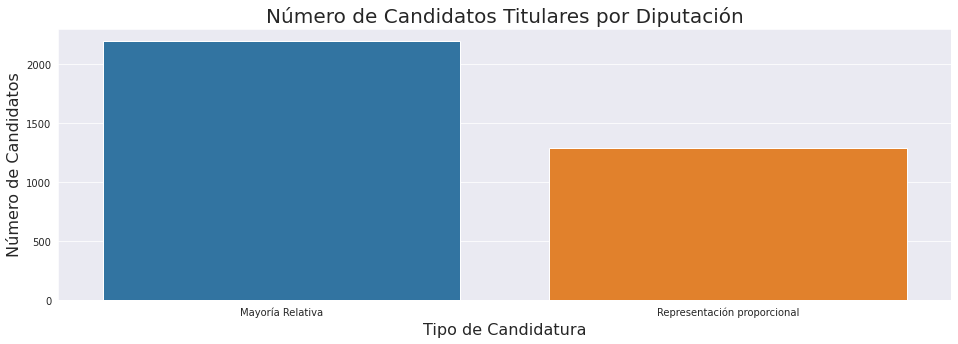

candidatura_tipo
MR    2191
RP    1290
Name: candidatura_tipo, dtype: int64


In [109]:
#cuento el número de candidatos titulares en cada tipo de candidatura: 

x = df_propietarios.groupby(['candidatura_tipo'])['candidatura_tipo'].agg('count')

plt.figure(figsize=(16,5))

sns.barplot(x = ['Mayoría Relativa', 'Representación proporcional'], y = x)

plt.title('Número de Candidatos Titulares por Diputación', fontsize = 20)

plt.xlabel('Tipo de Candidatura', fontsize = 16)
plt.ylabel('Número de Candidatos', fontsize = 16)

plt.show()

print(x)

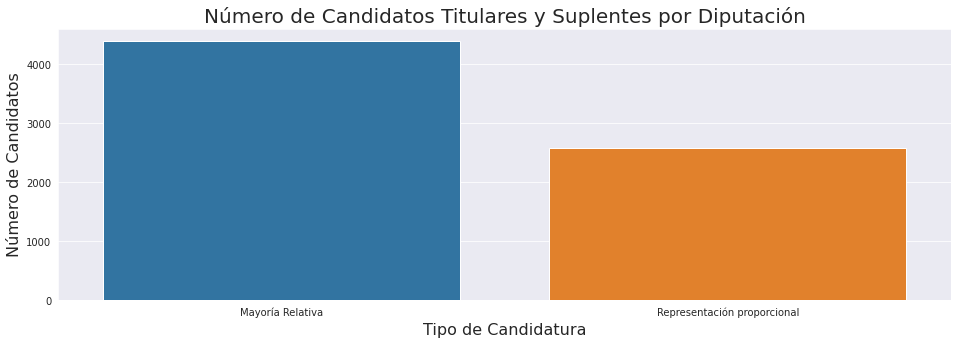

In [110]:
x = df.groupby(['candidatura_tipo'])['candidatura_tipo'].agg('count')

plt.figure(figsize=(16,5))

sns.barplot(x = ['Mayoría Relativa', 'Representación proporcional'], y = x)

plt.title('Número de Candidatos Titulares y Suplentes por Diputación', fontsize = 20)

plt.xlabel('Tipo de Candidatura', fontsize = 16)
plt.ylabel('Número de Candidatos', fontsize = 16)

plt.show()

## Analisis de las propuestas: 

Algo que debería de importarnos como ciudadanos a la hora de elegir un candidato a diputación son las propuestas que tienen estos candidatos. Si bien, es cierto que no podemos conocer TODAS las propuestas de los candidatos, al menos podemos conocer las propuestas registradas cuando entraron a la base de datos del INE. 

Algo que quisiera conocer es cuál es el tipo de propuesta "más popular" y analizar el enfoque que tienen las acutales campañas políticas, esto lo podemos hacer por región. 

In [111]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [112]:
#hago una columna que contenga todas las prupuestas de cada candidato: 
df_propietarios['propuestas_general'] = df_propietarios['propuesta_1'].astype(str) + df_propietarios['propuesta_2'].astype(str) + df['propuesta_genero'].astype(str)

In [113]:
propuestas_group  = df_propietarios.groupby(['nombre_candidato', 'entidad'])['propuestas_general'].max().reset_index()

<FreqDist with 2975 samples and 16013 outcomes>


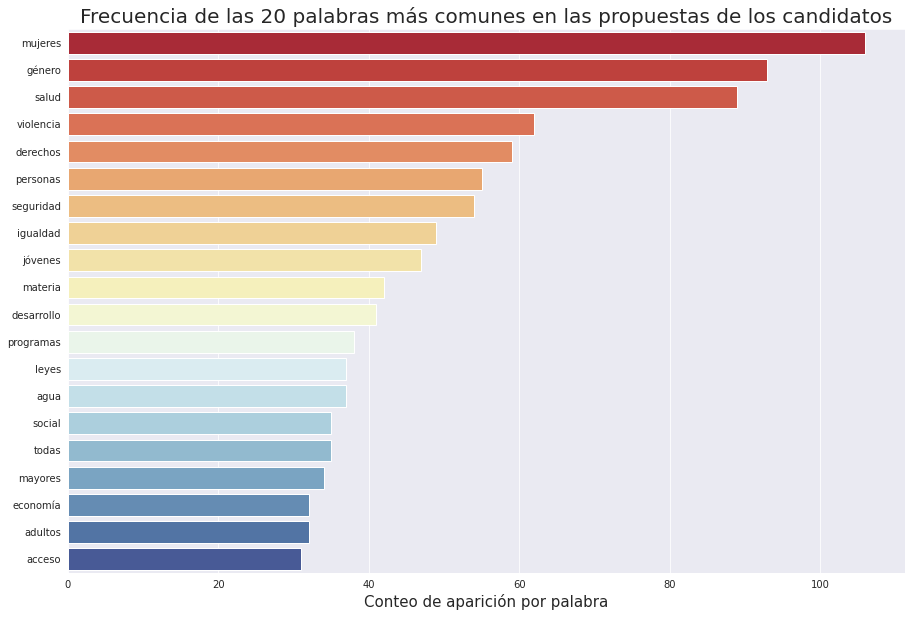

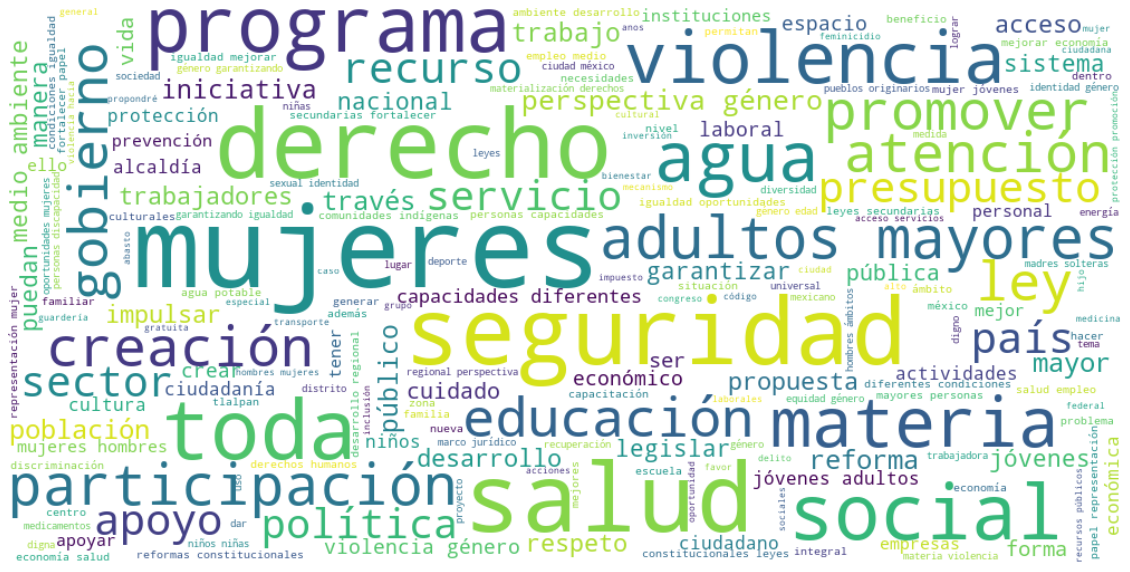

In [157]:
#print(freq_dist.most_common(20))

def palabras_comunes(num): 
  most_common_20 = np.array(list(map(lambda x: list(x), freq_dist.most_common(num))))

  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot()

  sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient = 'h');
  ax.set_title(f'Frecuencia de las {num} palabras más comunes en las propuestas de los candidatos', fontsize = 20)
  ax.set_xlabel('Conteo de aparición por palabra', fontsize = 15)
  ax.tick_params(axis='x')

  plt.show()





def nube_palabras(): 

  plt.figure(figsize=(20,20), facecolor='white')
  wordcloud = WordCloud(width=1000, height=500, max_font_size=100, background_color="white", mode = "RGB").generate(' '.join(all_words_except_stop_words))

  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.margins(x=0, y=0)

  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.margins(x=0, y=0)


  plt.show()

def propuestas_entidad(entidad):
  #filtro para los candidatos de cada entidad: 
  propuestas_prop  = propuestas_group[propuestas_group['entidad'] == f'{entidad}'].groupby('nombre_candidato')['propuestas_general'].max()

  #Hago una limpieza de los elementos: 

  propuestas_prop = propuestas_prop.str.lower()
  propuestas_prop = propuestas_prop.str.strip()
  propuestas_prop = propuestas_prop.str.replace('[^\w\s]', '')
  propuestas_prop = propuestas_prop.str.replace('\d', '')
  propuestas_prop = propuestas_prop.str.replace('\\n', '')
  propuestas_prop = propuestas_prop.dropna()

  #Separo las oraciones en palabras

  #ahora separo las oraciones en palabras: 

  tokenized = propuestas_prop.apply(nltk.word_tokenize)

  all_words = tokenized.sum()

  # Utilizamos FreqDist para analizar la distribución de frecuencia de nuestras palabras

  freq_dist = nltk.FreqDist(all_words)

  print(freq_dist)

  #quito los conectores o stopwords: 

  spanish_stop_words = stopwords.words('spanish')
  spanish_stop_words.append('así') #anexo este conector

  all_words_except_stop_words = [word for word in all_words if word not in spanish_stop_words]

  #filtro las palabras:
  freq_dist = nltk.FreqDist(all_words_except_stop_words)

  #palabras_comunes(20)
  #nube_palabras()


propuestas_entidad('CIUDAD DE MÉXICO')

In [217]:
# Defino una clase para poder manipular información de manera cómoda: 

class info_propuestas_entidad():
  def __init__(self, entidad):
    self.entidad  = entidad

  def propuestas_entidad(self):

    #filtro para los candidatos de cada entidad: 
    propuestas_prop  = propuestas_group[propuestas_group['entidad'] == f'{self.entidad}'].groupby('nombre_candidato')['propuestas_general'].max()

    #Hago una limpieza de los elementos: 

    propuestas_prop = propuestas_prop.str.lower()
    propuestas_prop = propuestas_prop.str.strip()
    propuestas_prop = propuestas_prop.str.replace('[^\w\s]', '')
    propuestas_prop = propuestas_prop.str.replace('\d', '')
    propuestas_prop = propuestas_prop.str.replace('\\n', '')
    propuestas_prop = propuestas_prop.dropna()

    #Separo las oraciones en palabras

    #ahora separo las oraciones en palabras: 

    tokenized = propuestas_prop.apply(nltk.word_tokenize)

    all_words = tokenized.sum()

    # Utilizamos FreqDist para analizar la distribución de frecuencia de nuestras palabras

    freq_dist = nltk.FreqDist(all_words)

    print(freq_dist)

    #quito los conectores o stopwords: 

    spanish_stop_words = stopwords.words('spanish')
    spanish_stop_words.append('así') #anexo este conector

    all_words_except_stop_words = [word for word in all_words if word not in spanish_stop_words]

    #filtro las palabras:
    freq_dist = nltk.FreqDist(all_words_except_stop_words)

    return freq_dist, all_words_except_stop_words, all_words

  def grafica_nube_palabras(self): 
    """ Regresa una nube de palabras con las principales propuestas realizadas en esa entidad """

    freq_dist, all_words_except_stop_words, all_words = self.propuestas_entidad()

    plt.figure(figsize=(20,20), facecolor='white')
    wordcloud = WordCloud(width=1000, height=500, max_font_size=100, background_color="white", mode = "RGB").generate(' '.join(all_words_except_stop_words))

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)


    plt.show()

  def grafica_palabras_comunes(self, num = 20): 
    """ Regresa una grafica de barras con las palabras más populares por entidad """

    freq_dist, all_words_except_stop_words, all_words = self.propuestas_entidad()
    most_common_20 = np.array(list(map(lambda x: list(x), freq_dist.most_common(num))))

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot()

    sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient = 'h');
    ax.set_title(f'Frecuencia de las {num} palabras más comunes en las propuestas de los candidatos', fontsize = 20)
    ax.set_xlabel('Conteo de aparición por palabra', fontsize = 15)
    ax.tick_params(axis='x')

    plt.show()


  def grafica_ngramas_comunes(self, ngrama = 2, palabras = 20): 
    """regresa una gráfica con los n-gramas más comunes de las propuestas"""  

    freq_dist, all_words_except_stop_words, all_words = self.propuestas_entidad()


    text = nltk.Text(all_words_except_stop_words)
    freq_dist_trigrams = nltk.FreqDist(list(ngrams(text, ngrama)))

    most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_trigrams.most_common(palabras))))

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot()

    sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient='h');
    ax.set_title(f'Frecuencia de las {ngrama}-gramas más comunes sin conectores', pad=10, fontsize = 20)
    ax.set_xlabel(f'Conteo de las {ngrama}-gramas más frecuentes', fontsize = 15)
    ax.tick_params(axis='x')

    plt.show()

<FreqDist with 2975 samples and 16013 outcomes>


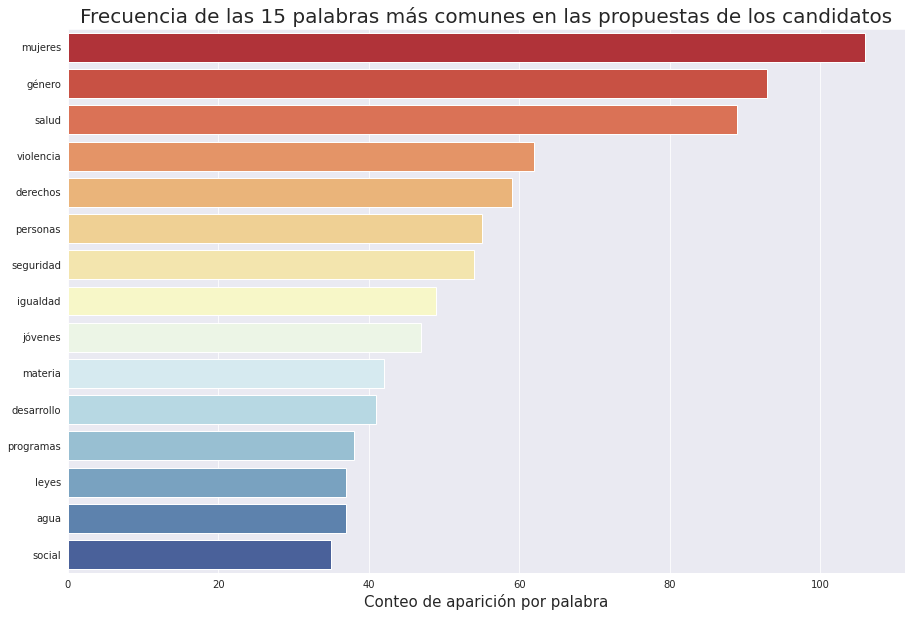

In [218]:
CDMX = info_propuestas_entidad('CIUDAD DE MÉXICO')
CDMX.grafica_palabras_comunes(num = 15)

<FreqDist with 2975 samples and 16013 outcomes>


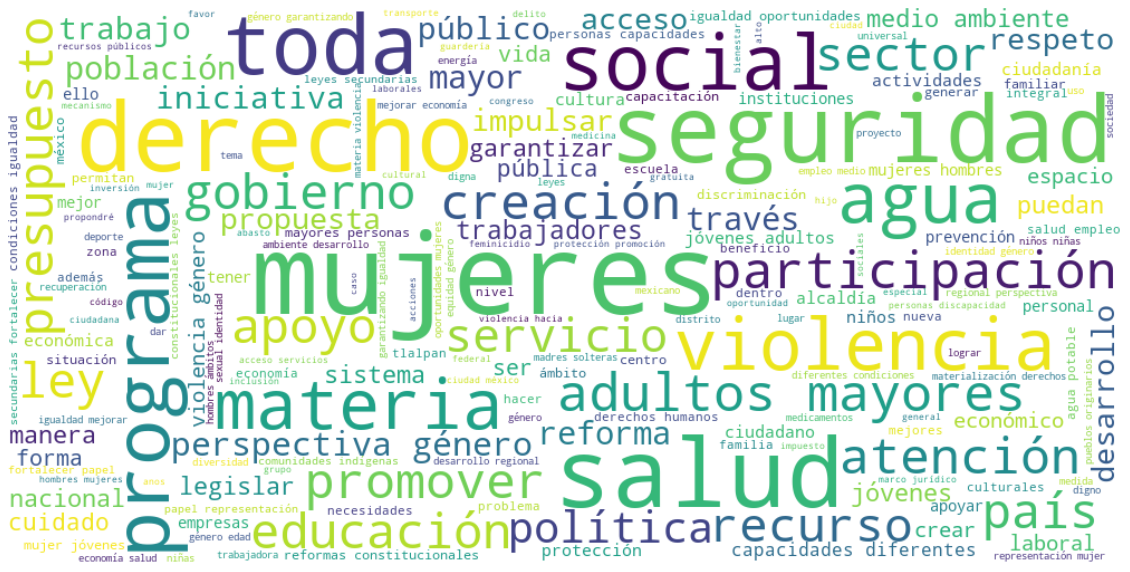

In [219]:
CDMX.grafica_nube_palabras()

<FreqDist with 2975 samples and 16013 outcomes>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


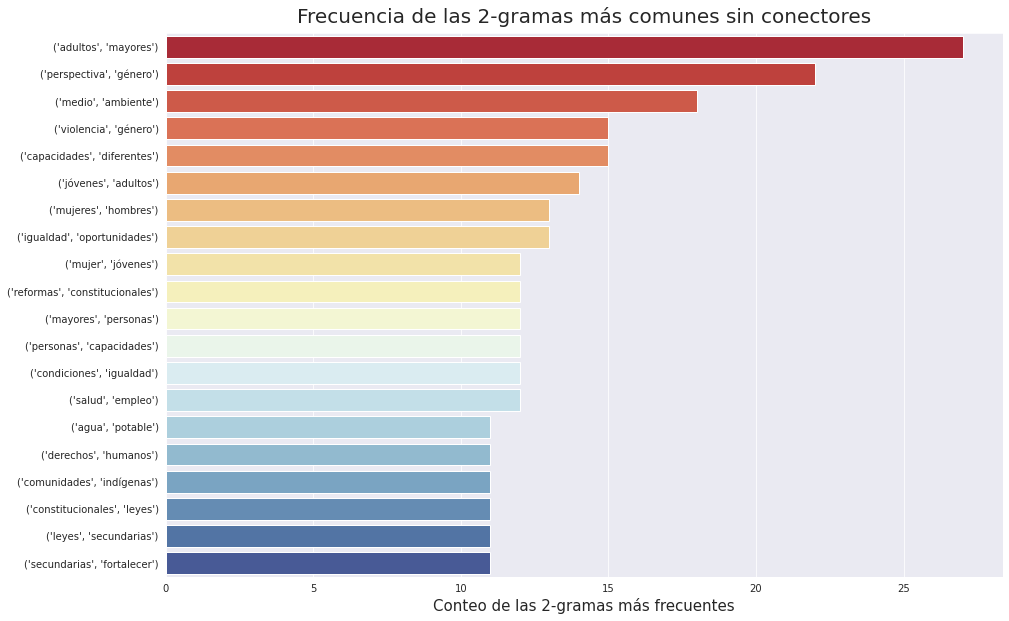

In [220]:
CDMX.grafica_ngramas_comunes()

In [196]:
def grafica_ngramas_comunes(ngrama = 2, palabras = 20): 
    
  text = nltk.Text(all_words_except_stop_words)
  freq_dist_trigrams = nltk.FreqDist(list(ngrams(text, ngrama)))

  most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_trigrams.most_common(palabras))))

  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot()

  sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient='h');
  ax.set_title('Frecuencia de las 20 trigramas más comunes con palabras vacías', pad=10)
  ax.set_ylabel('Count')
  ax.tick_params(axis='x', rotation=80)

  plt.show()

  